In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import scipy.ndimage as ndi

In [3]:
img_gt = Image.open('test_iou_gt.png')
img_det = Image.open('test_iou_det.png')

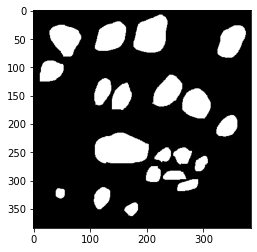

In [4]:
plt.imshow(img_det, 'gray')

In [14]:
class CocoPerf:
    
    def __init__(self, iou_thrs=None, which='precision'):
        """Not the same as COCO, since detection scores are not considered."""
        
        if iou_thrs is None:
            iou_thrs = np.linspace(.5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
        elif not isinstance(iou_thrs, (list, tuple)):
            iou_thrs = [iou_thrs]
        if isinstance(which, str):
            which = [which]
            
        self.iou_thrs = iou_thrs
        self.which = which
        
    def __call__(self, img_det, img_gt):
        
        results = self.evaluate(img_det, img_gt)

        return results[self.which[0]][0]

    def compute_ious(self, instances_det, instances_gt):

        ious = np.zeros((len(instances_det), len(instances_gt)))
        for idx_det, instance_det in enumerate(instances_det):
            for idx_gt, instance_gt in enumerate(instances_gt):
                points_det = instance_det.points
                points_gt = instance_gt.points
                iou = len(points_gt & points_det) / len(points_gt | points_det)
                ious[idx_det, idx_gt] = iou

        return ious

    def evaluate(self, img_det, img_gt):
                
        iou_thrs = self.iou_thrs
        num_thrs = len(iou_thrs)
        
        instances_gt = get_instances_coords(img_gt)
        instances_det = get_instances_coords(img_det)
        num_gt = len(instances_gt)
        num_det = len(instances_det)
            
        ious = self.compute_ious(instances_det, instances_gt)
        best_matches_det, best_matches_gt = self.match_instances(instances_det, instances_gt, ious, iou_thrs)
        matches_det, matches_gt = self.threshold_matches(best_matches_det, ious)
        metrics = self.metrics(matches_det, matches_gt, ious)

        
        results = {'instances_det': instances_det, 'instances_gt': instances_gt,
                   'ious': ious, 'matches_gt': matches_gt, 'matches_det': matches_det,
                   **metrics}
         
        return results

    def threshold_matches(self, best_matches_det, ious):
        
        iou_thrs = self.iou_thrs
        num_thrs = len(iou_thrs)
        num_det = ious.shape[0]
        num_gt = ious.shape[1]
        
        matches_gt  = np.full((num_thrs, num_gt), -1)
        matches_det  = np.full((num_thrs, num_det), -1)
        for idx_thrs, thrs in enumerate(iou_thrs):
            for idx_det in range(num_det):      
                idx_gt = best_matches_det[idx_det]
                if ious[idx_det, idx_gt] >= thrs:
                    matches_det[idx_thrs, idx_det]  = idx_gt
                    matches_gt[idx_thrs, idx_gt] = idx_det
                    
        return matches_det, matches_gt
    
    def metrics(self, matches_det, matches_gt, ious):
        
        iou_thrs = self.iou_thrs
        num_thrs = len(iou_thrs)
        
        tp_mask = matches_gt>-1
        fp_mask = matches_det==-1
        fn_mask = matches_gt==-1
        
        tp = np.sum(tp_mask, axis=1)
        fp = np.sum(fp_mask, axis=1)
        fn = np.sum(fn_mask, axis=1)

        precision = tp/(tp + fp)
        recall = tp/(tp + fn)

        sum_ious_tp = np.zeros(num_thrs)
        for idx_thrs in range(num_thrs):
            indices_gt = matches_det[idx_thrs]
            ious_tp = []
            for idx_det, idx_gt in enumerate(indices_gt):
                if idx_gt>-1:
                    ious_tp.append(ious[idx_det, idx_gt])
            sum_ious_tp[idx_thrs] = sum(ious_tp)
        panoptic = sum_ious_tp/(tp + 0.5*fp + 0.5*fn)
            
        return {'precision': precision, 'recall': recall, 'panoptic': panoptic}
        
    def match_instances(self, instances_det, instances_gt, ious, iou_thrs):
        
        num_det = len(instances_det)
        num_gt = len(instances_gt)
        num_thrs = len(iou_thrs)

        # Bipartite graph with weighted edges
        edges = []
        for idx_det in range(num_det): 
            for idx_gt in range(num_gt): 
                edges.append((idx_det, num_det+idx_gt, ious[idx_det, idx_gt]))

        current_det_nodes = set(range(num_det))
        current_gt_nodes = set(range(num_det, num_det+num_gt))
        sorted_edges = sorted(edges, key=lambda edge: edge[2], reverse=True)
        best_matches_gt  = np.full(num_gt, -1)
        best_matches_det  = np.full(num_det, -1)
        # Iterate over edges in decreasing iou order, removing the nodes from the graph
        for idx_det, idx_gt, iou in sorted_edges:
            if iou>0:
                if idx_gt in current_gt_nodes and idx_det in current_det_nodes:
                    best_matches_det[idx_det]  = idx_gt - num_det
                    best_matches_gt[idx_gt - num_det] = idx_det    
                    current_gt_nodes.remove(idx_gt)
                    current_det_nodes.remove(idx_det)
                    
        return best_matches_det, best_matches_gt
    
    def draw_results(self, results, img_shape, thresh_idx,
                     tp_color=(0, 255, 0), fp_color=(0, 0, 255), fn_color=(255, 0, 0)):
        
        instances_det = results['instances_det']
        instances_gt = results['instances_gt']
        matches_det = results['matches_det'][thresh_idx]
        matches_gt = results['matches_gt'][thresh_idx]
        
        img_tp = np.zeros((*img_shape, 3), dtype=np.int)
        img_fp = np.zeros_like(img_tp)
        img_fn = np.zeros_like(img_tp)
        img_gt = np.zeros_like(img_tp)
        for idx_det, idx_gt in enumerate(matches_det):
            if idx_gt==-1:
                self.draw_instance(img_fp, instances_det[idx_det], fp_color)
            else:
                self.draw_instance(img_tp, instances_det[idx_det], tp_color)
        for idx_gt, idx_det in enumerate(matches_gt):
            if idx_det==-1:
                self.draw_instance(img_fn, instances_gt[idx_gt], fn_color)
                
        for instance in instances_gt:
            self.draw_instance(img_gt, instance, (255, 255, 255))
            
        gt_alpha = 0.2
        img_final = (img_tp + img_fp + img_fn + (1-gt_alpha)*img_gt)/(2+gt_alpha)
        img_final = np.round(img_final).astype(np.uint8)
            
        return img_final
      
    def draw_instance(self, img, instance, color):
        
        num_cols = img.shape[1]
        for index in instance.points:
            row = index//num_cols
            col = index - row*num_cols
            img[row, col] = color
    
class Instance:
    
    def __init__(self, id, points):
        
        if not isinstance(points, set):
            points = set(map(tuple, points))
            
        self.id = id
        self.points = points
        
    def center_of_mass(self):
        
        return np.mean(self.points, axis=0)
    
def get_instances_coords(img):

    se = np.ones((3, 3))
    img_label, num_inst = ndi.label(img, se)

    indices = np.arange(1, num_inst + 1)
    inst_points = ndi.labeled_comprehension(img_label, img_label, indices, 
                                             lambda v, p: (v[0], p), list, None, 
                                             pass_positions=True)
    inst_points = [Instance(v[0]-1, set(v[1])) for v in inst_points]
    return inst_points

cp = CocoPerf(iou_thrs=[0.2, 0.4])            
results = cp.evaluate(img_det, img_gt)
print(results['matches_gt'])
print(results['matches_det'])
print(results['precision'])
print(results['recall'])
print(results['panoptic'])
cp(img_det, img_gt)

[[ 0  1  2 -1  5 -1  7 -1 10 -1 12 -1 -1 -1 15 -1 -1 -1 -1 -1 -1]
 [-1  1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 15 -1 -1 -1 -1 -1 -1]]
[[ 0  1  2 -1 -1  4 -1  6 -1 -1  8 -1 10 -1 -1 14 -1 -1 -1 -1]
 [-1  1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 14 -1 -1 -1 -1]]
[0.4  0.15]
[0.38095238 0.14285714]
[0.16253865 0.09183914]


0.4

In [6]:
img_final = cp.draw_results(results, np.array(img_gt).shape, 0)

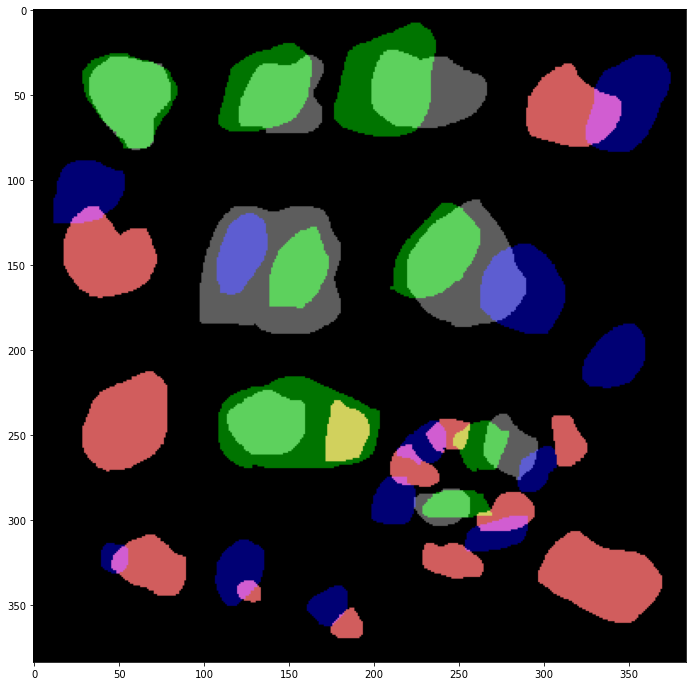

In [7]:
plt.figure(figsize=[12,12])
plt.imshow(img_final)

In [72]:
8/21

0.38095238095238093

In [125]:
iou_thrs = np.linspace(.5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
num_det = ious.shape[0]
num_gt = ious.shape[1]
num_thrs = len(iou_thrs)

edges = []
for idx_det in range(ious.shape[0]): 
    for idx_gt in range(ious.shape[1]): 
        edges.append((idx_det, num_det+idx_gt, ious[idx_det, idx_gt]))

#edges = graph.edges(data=True)
current_det_nodes = set(range(num_det))
current_gt_nodes = set(range(num_det, num_det+num_gt))
sorted_edges = sorted(edges, key=lambda edge: edge[2], reverse=True)
#current_nodes = set(graph.nodes)
best_matches_gt  = np.full(num_gt, -1)
best_matches_det  = np.full(num_det, -1)
for idx_det, idx_gt, iou in sorted_edges:
    if iou>0:
        if idx_gt in current_gt_nodes and idx_det in current_det_nodes:
            best_matches_det[idx_det]  = idx_gt - num_det
            best_matches_gt[idx_gt - num_det] = idx_det    
            current_gt_nodes.remove(idx_gt)
            current_det_nodes.remove(idx_det)
    
matches_gt  = np.full((num_thrs, num_gt), -1)
matches_det  = np.full((num_thrs, num_det), -1)
for idx_thrs, thrs in enumerate(iou_thrs):
    for idx_det in range(ious.shape[0]):      
        idx_gt = best_matches_det[idx_det]
        if ious[idx_det, idx_gt] >= thrs:
            matches_det[idx_thrs, idx_det]  = idx_gt
            matches_gt[idx_thrs, idx_gt] = idx_det
            
print(matches_gt)
print(matches_det)

[[-1  4  3  0  2]
 [-1  4  3  0  2]
 [-1  4  3  0  2]
 [-1 -1  3  0  2]
 [-1 -1  3  0  2]
 [-1 -1  3  0  2]
 [-1 -1  3  0  2]
 [-1 -1 -1  0  2]
 [-1 -1 -1  0  2]
 [-1 -1 -1  0 -1]]
[[ 3 -1  4  2  1]
 [ 3 -1  4  2  1]
 [ 3 -1  4  2  1]
 [ 3 -1  4  2 -1]
 [ 3 -1  4  2 -1]
 [ 3 -1  4  2 -1]
 [ 3 -1  4  2 -1]
 [ 3 -1  4 -1 -1]
 [ 3 -1  4 -1 -1]
 [ 3 -1 -1 -1 -1]]


In [101]:
idx_gt in current_gt_nodes

False

In [64]:
set([1, 2, 3]) | set([3, 4, 5])

{1, 2, 3, 4, 5}